# Generating Multi-Channel EEG Segments via Generative Adversarial Networks
#### Galen Pogoncheff
#### CSCI 7000 - Applied Deep Learning
___

### Introduction

Electroencephalography (EEG) devices enable the recording of brain activity by measuring electrical activity at the scalp of a patient.  This electrical activity arises from the electric impulses that are generated as brain cells communicate.  EEG devices  offer a non-invasive method for diagnosing and evaluating a wide range of disorders including, but not limited to, epilepsy, sleep disorders, and strokes. A typical EEG device utilizes numerous electrodes to record brain activity from multiple locations of the brain.  Each electrode is used to capture a time-series recording of this electrical potential.  Therefore, an EEG device with *m* electrode derivations (excluding reference derivations) provides *m* channels of time-series data, as depicted by the EEG reading in the image below.

Using TensorFlow backend.


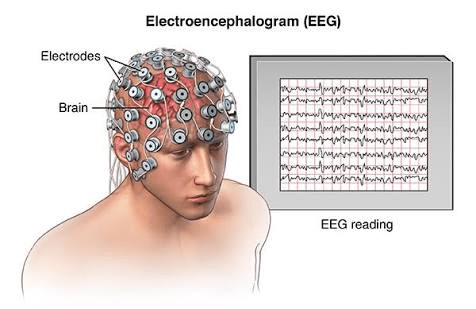

In [0]:
from keras.preprocessing.image import load_img
load_img('/content/drive/My Drive/EEG GAN/eeg2 gan/eeg device.png')

Deep learning techniques have proved to be successful in automating diagnosis and/or detection of cognitive processes based on the signal data of EEG recordings. Two notable difficulties in automating such processes with deep learning techniques are the stochasticity of the signal itself and inherent variability of the brain signals between different patients.  The characteristics of brain signals can vary widely due to a subject's mental conditions, medication consumption, age, and a variety of other factors.  As a result, in order to develop a robust machine learning model that generalizes well to a general population, it is often critical to construct a training dataset that incorporates data from many subjects.  Unfortunately, however, recording such data is time consuming and labeling the data typically requires domain expertise.  In many machine learning tasks that are subject to similar constraints (i.e., insufficient training data) Generative Adversarial Networks (GANs) have been successfully employed to generate synthetic training data that, when used alongside the original training data, can help bost the performance of the deep learning model [1, 2, 3].  

The goal of this project was to train a multi-channel signal generating/discriminating GAN so that the trained generator can ultimately be used to generate segments of multi-channel EEG signal data.  Provided that the generated synthetic signal segments are highly resemblant of real EEG signal data, EEG training datasets could potentially be augmented with the addition of these synthetic segments to improve the robustness of the resulting deep learning model.

### Data
The dataset used in this project is a collection of EEG and EOG (electrooculography) recordings from 20 subjects during Maintenance of Wakefulness Tests ([dataset link](https://zenodo.org/record/3251716#.XqW1ei2ZOCN), [associated paper](https://academic.oup.com/sleep/article/43/1/zsz225/5574726#191469750)). Maintenance of Wakefulness Tests are often used to assess the ability of a patient to remain awake during periods of low activity.  Such tests can aid in the diagnosis of sleep disorders such as excessive daytime sleepiness.  Each EEG recording in this dataset contains 2 channels of EEG data (from the left and right occipital regions of the brain) and 2 channels of EOG data (used to measure eye movements).  For the purpose of this project, I only considered the 2 channels of EEG data, however, the ideas presented in this project are applicable to EOG data as well.  This biological signal data was sampled at 200Hz, implying that 200 data points are collected from each signal channel per second of time.  The labels that accompany this signal data were provided by domain experts.  A label is associated with each sample and this label designates the wakefulness of the subject.  As compared to other classes, the `awake` class is over-represented in this dataset.  As a result, training a deep learning model to predict sleepy states may be of difficulty due to insufficient class examples.  In consideration of this, my Generative Adversarial Network is trained using only signal segments that belong to these "sleepy" classes (i.e., the segments with class label 1,2, or 3) so that, after training, synthetic signal segments may be generated to help resolve this class imbalance.

In [5,6,7,8,9,10,11,21] and similar studies, the EEG signal segments that are input into a machine learning model span short time durations, such as 0.5-second, 1-second, or 5-seconds intervals.  My GAN model learns to generate signal segments with 128 total samples.  Given the 200Hz sampling rate of the training data, these generated segments roughly equate to signal segments of just over 0.5-seconds in length.

In the code cells below, signal segments of the training data are shown to illustrate the structure of these time-series data segments.  This cell also include methods for loading the signal data from a matlab file, extracting the labels for each training signal segment, and filtering out the segments belonging to the `awake` class. 

In [0]:
# Example code cell to show samples from the training data

import numpy as np
from scipy.io import loadmat

def get_labeled_segments(data_full, labels, samples_per_seg=128):
    '''
    Iterate over the full signal recording and collect contiguous segments
    of 128 samples.  Only segments with a uniform class label across all
    of its 128 samples are considered.
    '''
    X, y = [], []
    i = 0
    while i+samples_per_seg < data_full.shape[1]:
        ys = labels[i:i+samples_per_seg]
        if np.all(np.array(ys) == 0):
            # All samples belong to 'awake' class
            X.append(data_full[:,i:i+samples_per_seg])
            y.append(0)
        elif np.all(np.array(ys) != 0):
            # All samples belong to a class other than 'awake', 
            # i.e., an under-represented class.
            X.append(data_full[:,i:i+samples_per_seg])
            y.append(1)
        i += samples_per_seg
    return np.array(X), np.array(y)

def load_data(matlab_filename, samples_per_seg=128):
    '''
    Given the matlab recording filename, extract the signal channels and labels.
    '''
    matlab_data = loadmat(matlab_filename)['Data'][0][0]
    fs = matlab_data[0].flatten()[0]
     
    # Separate the eeg and eog channel data
    eeg_o1 = matlab_data[1]
    eeg_o2 = matlab_data[2]
    eog_c1 = matlab_data[3]
    eog_c2 = matlab_data[4]

    # Extract the labels
    labels = matlab_data[5]

    data_full = np.array([eeg_o1.T[0], eeg_o2.T[0], eog_c1.T[0], eog_c2.T[0]])
    
    X, y = get_labeled_segments(data_full, labels.T[0], samples_per_seg=128)

    # Only return EEG channels of the signal data
    return X[:,:2,:], y


signal_examples, labels = load_data('/content/drive/My Drive/EEG GAN/eeg2 gan/3J4W.mat')

# Filter out 'awake' segments
train_examples = signal_examples[np.where(labels != 0)[0]]

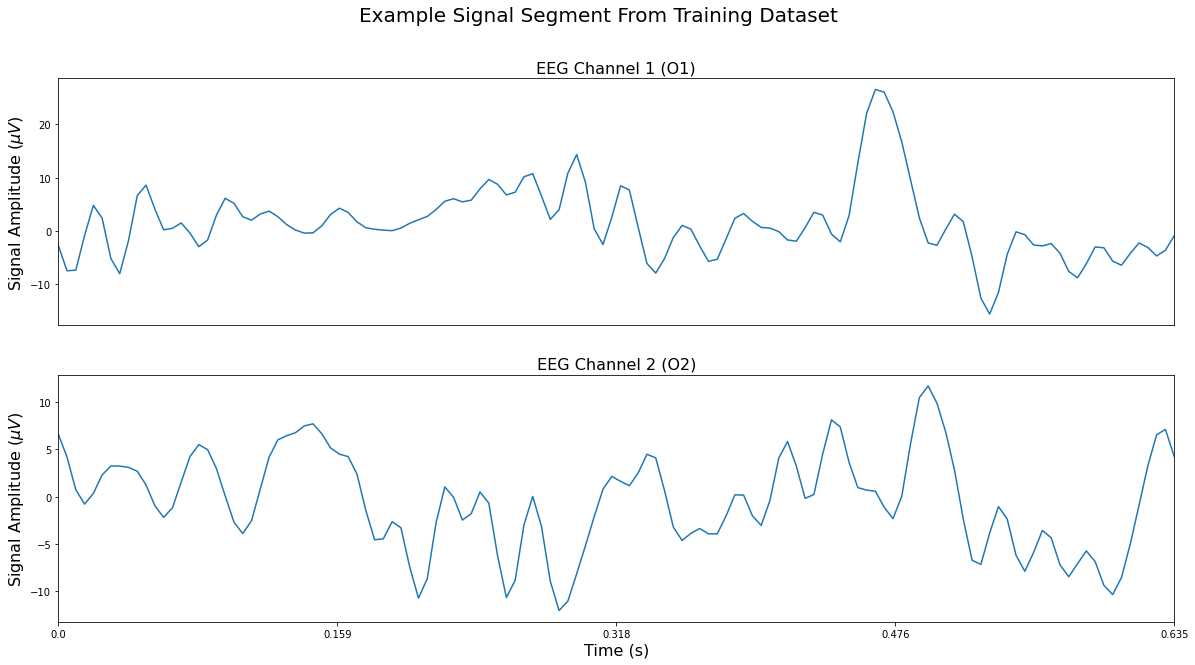

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

sample_index = 20

fig, ax = plt.subplots(2, figsize=(20, 10))

for i in range(train_examples.shape[1]):
  ax[i].plot(train_examples[sample_index,i,:])
  ax[i].set_title('EEG Channel {} (O{})'.format(i+1, i+1), size=16)
  ax[i].set_ylabel('Signal Amplitude ($\mu V$)'.format(i+1), size=16)
  ax[i].set_xlim([0,127])

ax[0].set_xticks([])
ax[-1].set_xlabel('Time (s)', size=16)
ax[-1].set_xticks(np.linspace(0,127,5))
ax[-1].set_xticklabels(np.round(np.linspace(0,127,5)/200, 3))

plt.suptitle('Example Signal Segment From Training Dataset', size=20)
plt.show()

### Network Architecture and Training

The GAN network architecture that I have developed for multi-channel EEG signal segment generation is depicted below. 

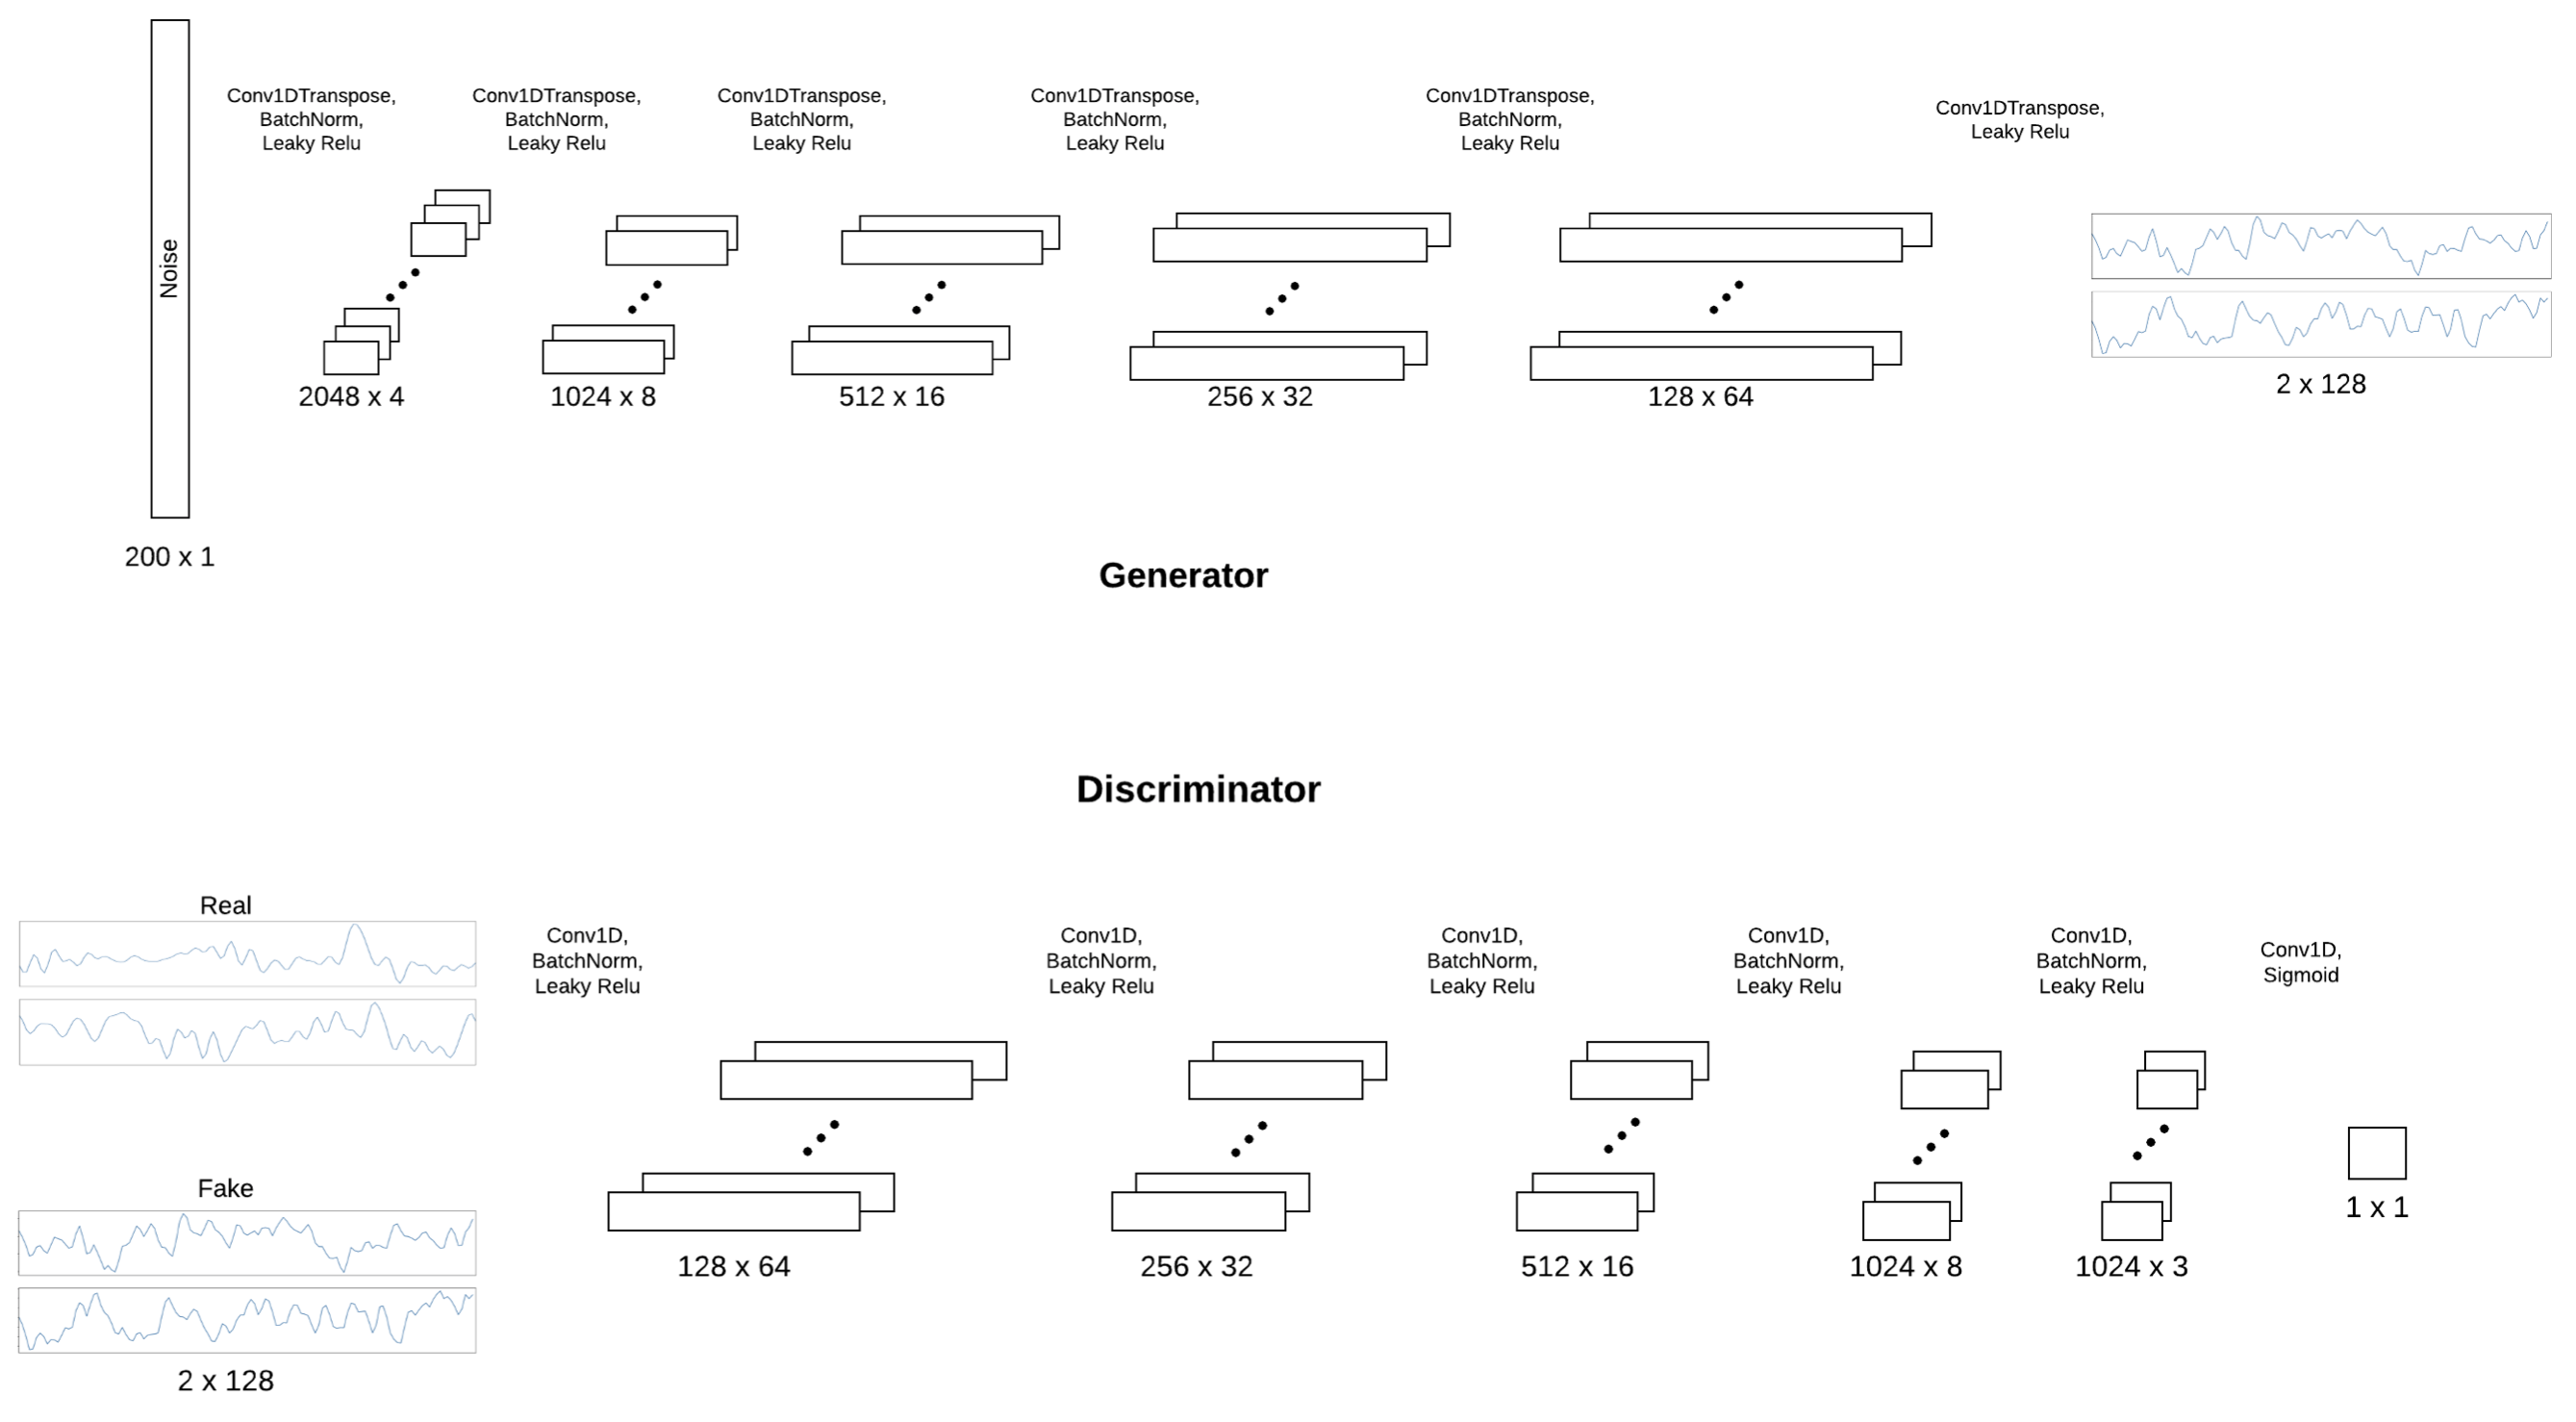

In [0]:
load_img('/content/drive/My Drive/EEG GAN/eeg2 gan/gan architecture.png')

Inspired by the [DCGAN](https://arxiv.org/abs/1511.06434) architecture [12] (a popular GAN architecture for image generation), the generator of my network uses convolutional layers with decreasing channel depth as the resolution of the latent feature maps are increased with transpose convolutions. The input to the generator is a 200 element vector whose values are drawn form a normal distribution with mean 0 and unit variance. The output of the generator network (and input to the discriminator network) is a 2x128 tensor, intended to replicate 128 contiguous samples of two-channel EEG data. 

The architecture of the discriminator is not dissimilar from typical binary classification convolutional neural networks.  This network component uses a series of convolutional blocks and terminates with a convolutional layer with a sigmoid activation that outputs a 1x1 tensor, which is ultimately used by discriminator to distinguish between real and fake signal segments.  Each convolutional block in the discriminator contains a convolutional layer which is followed by a batch normalization layer and a Leaky Relu activation function.

Batch Normalization is a layer-wise mehod of normalizing the inputs to the subsequent hidden layer for each batch of training data (similar to how the data presented at the input layer of a network is typically scaled).  This transformation can enable faster and more stable network training by reducing internal covariate shift [13].

Batch Normalization Algorithm


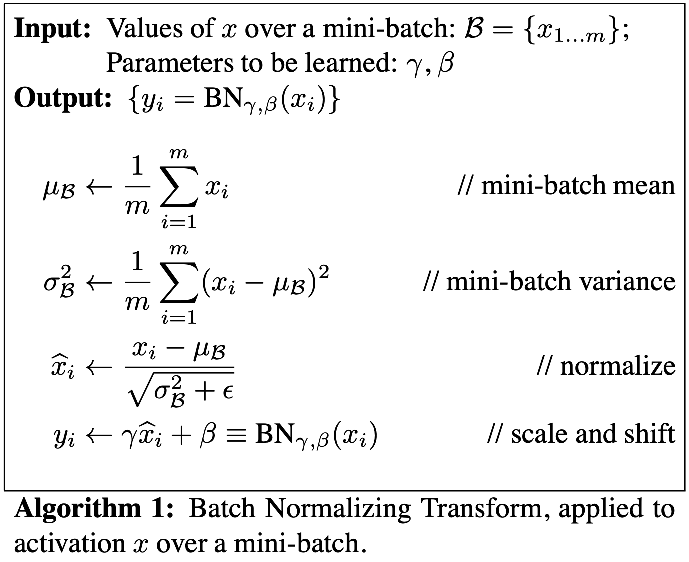

In [0]:
print('Batch Normalization Algorithm')
load_img('/content/drive/My Drive/EEG GAN/eeg2 gan/batch norm.png', target_size=(int(1124*.5), int(1378*.5)))

Leaky Relu Activation Function


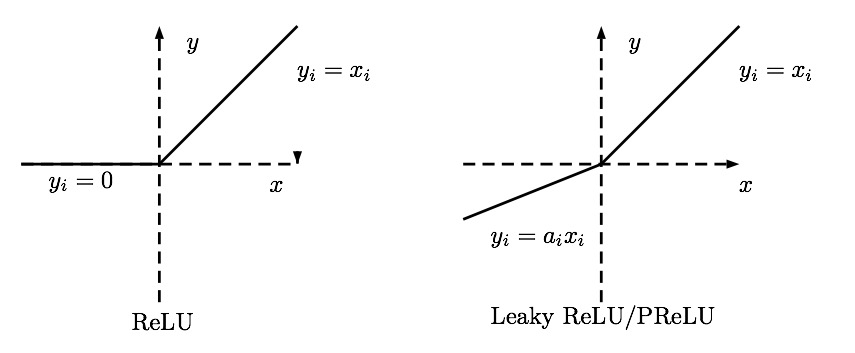

In [0]:
print('Leaky Relu Activation Function')
load_img('/content/drive/My Drive/EEG GAN/eeg2 gan/leaky relu.png')

My GAN is trained in a conventional, iterative apporach.  As proposed in the original GAN paper by Ian Goodfellow et al. [14], the network is train such that the generator (G) and discriminator (D) are optimized to solve 

$$\min_G \max_D V(G, D) = \mathbb{E}_{x \sim p_{data}(x)}\left[ \log(D(x)) \right]
+ \mathbb{E}_{z \sim p_z(z)} \left[ \log(1 - D(G(z))) \right]
$$

where $p_{data}$ is the distribution of the real data (in my case, the real EEG signal segments),  $z \sim p_z(z)$ is a random latent vector sampled sampled from some probability distribution $p_z$, $D(x)$ is the prediction of the discriminator for a data sample $x$, and $G(z)$ is the synthetic signal segment produced by the generator.  This equation is optimized by iteratively updating the discriminator network to maximize $\log(D(x)) + \log(1 - D(G(z)))$ and then updating the generator to minimize $\log(1 - D(G(z)))$.


In each epoch, the following steps are performed to optimize these expressions:
1. Forward a batch of real data through the dricriminator, calculate the binary cross entropy loss over this batch, and backpropagate the gradients with respect to the loss function.
2. Forward a fake batch of data through the discriminator, calculate the binary cross entropy loss over this batch, and backpropagate the gradients with respect to the loss function.
3. At this point, the gradients from steps 1 and 2 have been aggregated. Now, updating the parameters of discriminator using an Adam optimization method and the computed gradients enables us to take a step towards maximizing $\log(D(x)) + \log(1 - D(G(z)))$.
4. Calculate the generator's loss by computing the binary cross entropy loss between the discriminator's outputs from step 2 and the label values for **real** data samples (since, the goal of the generator is to generate realistic samples).
5. Backpropagate the gradients with respect to the generator's loss function to the parameters of the generator and update these parameters using an Adam optimization method.  By performing steps 4 and 5, G is updated to maximize $\log(D(G(z)))$, which is a suffient approximation for minimizing $\log(1 - D(G(z)))$.

The specific optimizers that are used in my network were Adam optimizers. One Adam optimizer was used for each network (as these optimizers should adapt indivisually for each network).  I found that learning rates of 0.0001 and 0.00001 for the generator and the discriminator, respectively, led to relatively stable training of this network.  An additional technique that I used to improve training stability was to use a regularization technique called label smoothing which helps prevent a network from making predictions with too much condifence.  With regards to the binary class labels of "real" and "fake", this involved using labels of 0.9 and 0.1, respectively, as opposed to 1 and 0.  Using label smoothing for the "real" class is a common technique while training GANs to improve their stability as it can help prevent the discriminator from becoming too confident.  Smoothing the "fake" class label is not as common, however, I found this to improve the training process in my specific use case.

___
# Implementation

In [0]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
# Set random seed values for reproducibility
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [0]:
# Load EEG data from specified file path
def load_data(datapath, bio_channels=2, samples_per_seg=128):
  data = np.load(datapath)
  return data[:,:bio_channels,:samples_per_seg]

# Scale each signal segment to a min amplitude of 0 and max amplitude of 1
def normalize_channels(data):
  channel_stats = []
  data_normed = np.zeros_like(data)
  for channel in range(data.shape[1]):
    channel_data = data[:,channel,:]
    data_normed[:,channel,:] = (channel_data - np.min(channel_data))/(np.max(channel_data) - np.min(channel_data))
    channel_stats.append((np.min(channel_data), np.max(channel_data)))
  return data_normed, channel_stats

In [0]:
# Alpha value for Leaky Relu
ALPHA = 0.2


# Generator Network
class eeg2_Generator(nn.Module):
    def __init__(self, latent_dims, bio_channels):
      super(eeg2_Generator, self).__init__()
      self.main = nn.Sequential(
        nn.ConvTranspose1d(latent_dims, 2048, kernel_size=4, stride=1, padding=0, bias=False,),
        nn.BatchNorm1d(2048),
        nn.LeakyReLU(ALPHA, inplace=True),

        nn.ConvTranspose1d(2048, 1024, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm1d(1024),
        nn.LeakyReLU(ALPHA, inplace=True),

        nn.ConvTranspose1d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm1d(512),
        nn.LeakyReLU(ALPHA, inplace=True),

        nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm1d(256),
        nn.LeakyReLU(ALPHA, inplace=True),

        nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm1d(128),
        nn.LeakyReLU(ALPHA, inplace=True),

        nn.ConvTranspose1d(128, bio_channels, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(ALPHA, inplace=True)
      )

    def forward(self, input):
      return self.main(input)


# Discriminator Network
class eeg2_Discriminator(nn.Module):
    def __init__(self, bio_channels, samples_per_seg):
      super(eeg2_Discriminator, self).__init__()
      self.main = nn.Sequential(
        nn.Conv1d(bio_channels, samples_per_seg, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(ALPHA, inplace=True),

        nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm1d(256),
        nn.LeakyReLU(ALPHA, inplace=True),

        nn.Conv1d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm1d(512),
        nn.LeakyReLU(ALPHA, inplace=True),

        nn.Conv1d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm1d(1024),
        nn.LeakyReLU(ALPHA, inplace=True),

        nn.Conv1d(1024, 1024, kernel_size=4, stride=2, padding=0, bias=False),
        nn.BatchNorm1d(1024),
        nn.LeakyReLU(ALPHA, inplace=True),

        nn.Conv1d(1024, 1, kernel_size=3, stride=1, padding=0, bias=False),
        nn.Sigmoid()
      )

    def forward(self, input):
      return self.main(input)


# GAN Network
class eeg2_GAN():
  def __init__(self, bio_channels, latent_dims, samples_per_seg):
    self.bio_channels = bio_channels
    self.samples_per_seg = samples_per_seg
    self.latent_dims = latent_dims
    self.device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

    self.generator = self.get_generator().to(self.device)
    self.generator.apply(self.initialize_layers)

    self.discriminator = self.get_discriminator().to(self.device)
    self.generator.apply(self.initialize_layers)

  def initialize_layers(self, module):
    # Method for weight initialization of convolutional and batch normalization layers
    # https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html#sphx-glr-beginner-dcgan-faces-tutorial-py
    classname = module.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(module.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(module.weight.data, 0.0, 0.02)
        nn.init.constant_(module.bias.data, 0)

  def save_model(self, path_prefix):
    # Save model to file
    torch.save(self.generator.state_dict(), path_prefix + 'g.pth')
    torch.save(self.discriminator.state_dict(), path_prefix + 'd.pth')
    return path_prefix + 'g.pth', path_prefix + 'd.pth'

  def get_generator(self):
    generator = eeg2_Generator(self.latent_dims, self.bio_channels)
    return generator
  
  def get_discriminator(self):
    discriminator = eeg2_Discriminator(self.bio_channels, self.samples_per_seg)
    return discriminator

  def train(self, X_train, epochs=75, batch_size=128, lr_g=1e-4, lr_d=1e-5, output_path=None, verbose=True):

    # Create batch of 4 latent vectors that we will use to visualize the generator's behavior over time
    fixed_noise = torch.randn(4, self.latent_dims, 1, device=self.device)

    # Smoothed binary labels for real (1) and fake (0) classes
    y_real = 0.9
    y_fake = 0.1

    loss_func = nn.BCELoss()
    optimizer_generator = optim.Adam(self.generator.parameters(), lr=lr_g)
    optimizer_discriminator = optim.Adam(self.discriminator.parameters(), lr=lr_d)

    dataloader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True, num_workers=2)
  
    generator_loss_hist = []
    discriminator_loss_hist = []
    iters = 0

    for epoch in range(epochs):
      for batch_i, data in enumerate(dataloader, 0):
        # Update discriminator - maximize log(D(x)) + log(1 - D(G(z)))

        # Train with real data
        self.discriminator.zero_grad()
        real_batch = data.to(self.device, dtype=torch.float)
        b_size = real_batch.size(0)
        label = torch.full((b_size,), y_real, device=self.device)

        # Forward pass real data through discriminator
        output = self.discriminator(real_batch).view(-1)
        # Calculate loss and backprop
        discriminator_loss_real = loss_func(output, label)
        discriminator_loss_real.backward()
        D_x = output.mean().item()

        # Train with generated data
        # Generate batch of latent vectors
        noise = torch.randn(b_size, self.latent_dims, 1, device=self.device)
        # Generate fake image batch with G
        fake_batch = self.generator(noise)
        label.fill_(y_fake)

        # Forward pass fake data through discriminator
        output = self.discriminator(fake_batch.detach()).view(-1)
        # Calculate loss and backprop
        discriminator_loss_fake = loss_func(output, label)
        discriminator_loss_fake.backward()
        D_G_z1 = output.mean().item()

        # Add the gradients from the all-real and all-fake batches
        discriminator_loss_total = discriminator_loss_real + discriminator_loss_fake

        # Update discriminator
        optimizer_discriminator.step()


        # Update generator - maximize log(D(G(z)))
        self.generator.zero_grad()
        label.fill_(y_real)

        output = self.discriminator(fake_batch).view(-1)
        # Calculate loss and backprop
        generator_loss = loss_func(output, label)
        generator_loss.backward()

        D_G_z2 = output.mean().item()

        # Update generator
        optimizer_generator.step()

        # Periodically print training losses
        if batch_i % 16 == 15:
          print('[{}/{}]\tLoss D: {}\tLoss G: {}\tD(x): {}\tD(G(z)): {} / {}'\
                .format(epoch,epochs,round(discriminator_loss_total.item(),5), \
                        round(generator_loss.item(),5), round(D_x,5), round(D_G_z1,5), round(D_G_z2,5)))

        # Save Losses for plotting later
        generator_loss_hist.append(generator_loss.item())
        discriminator_loss_hist.append(discriminator_loss_total.item())

      # Check how the generator is doing by saving G's output on fixed_noise
      if (output_path is not None):
        with torch.no_grad():
          fake = self.generator(fixed_noise).detach().cpu()
          fig, ax = plt.subplots(fake.size(0), 1, figsize=(18, 12))
          for i in range(fake.size(0)):
            ax[i].plot(fake[i,0,:].view(-1))
            ax[i].set_xlim([0,128])
            if i < fake.size(0)-1:
              ax[i].set_xticks([])
          plt.savefig(output_path+'gensignal_epoch{}.png'.format(epoch))
          plt.clf()
          if epoch > 50:
            self.save_model(output_path+'epoch{}'.format(epoch))
      iters += 1

      if (verbose):
        # Show generated signals after ever epoch
        with torch.no_grad():
          num_samps = 2
          test_noise = torch.randn(num_samps, self.latent_dims, 1, device=self.device)
          fig, ax = plt.subplots(num_samps, 1, figsize=(18, 6))
          fake = self.generator(test_noise).detach().cpu()
          for i in range(num_samps):
            ax[i].plot(fake[i,0,:].view(-1))
          plt.show()

    return generator_loss_hist, discriminator_loss_hist

In [0]:
# Load 4096 real 2-channel EEG samples
data = load_data('/content/drive/My Drive/EEG GAN/3_sec_segs/X_real.npy', bio_channels=2, samples_per_seg=128)
X_train, channel_stats = normalize_channels(data)
X_train = X_train[:4096]

In [0]:
gan = eeg2_GAN(bio_channels=2, latent_dims=200, samples_per_seg=128)

In [0]:
# Train GAN for 150 epochs
gl, dl = gan.train(X_train, epochs=150, output_path='/content/drive/My Drive/EEG GAN/eeg2 gan/test2/')

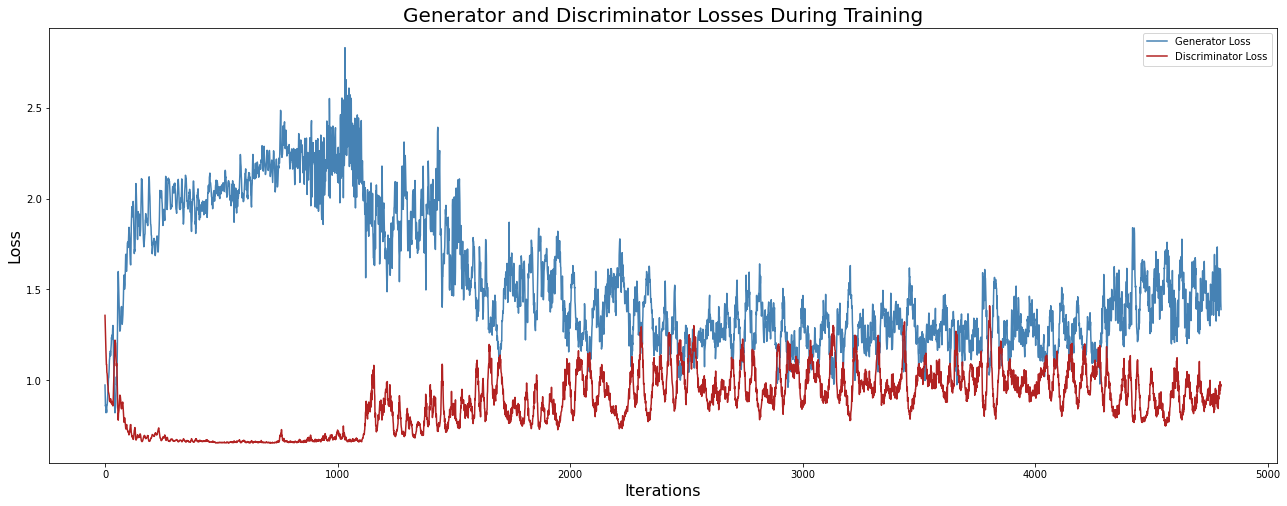

In [0]:
# Inspired by training evaluation and monitoring feaured in 
# https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

generator_losses = np.load('/content/drive/My Drive/EEG GAN/eeg2 gan/test2/glosses.npy')
discriminator_losses = np.load('/content/drive/My Drive/EEG GAN/eeg2 gan/test2/dlosses.npy')

fig, ax = plt.subplots(figsize=(22,8))

ax.plot(generator_losses,label='Generator Loss', color='steelblue')
ax.plot(discriminator_losses,label='Discriminator Loss', color='firebrick')

ax.set_title('Generator and Discriminator Losses During Training', size=20)
ax.set_xlabel('Iterations', size=16)
ax.set_ylabel('Loss', size=16)
ax.legend(loc='upper right')
plt.show()

___
# Results and Evaluation

When training this GAN, it was apparent that the generator and discriminator losses experienced a reaonable amount of fluctuation.  An example of this fluctuation can be seen in the figure above - after about 25,000 iterations, the losses of the two networks was fairly stable until approximately iteration 4,000 when the discriminator loss began to decrease and the generator loss began to increase.  Throughout the training process I saved states of the model over time so that I could analyze the quality of the generated data at multiple stages of the training process.

Depicted below are 4 sample segments (each of 128 samples) produced by the generator after (a) 1, (b) 25, (c) 50, (d) 75, and (e) 115 epochs of training. Note that these sample segments only depict the first channel of the generated EEG segment.

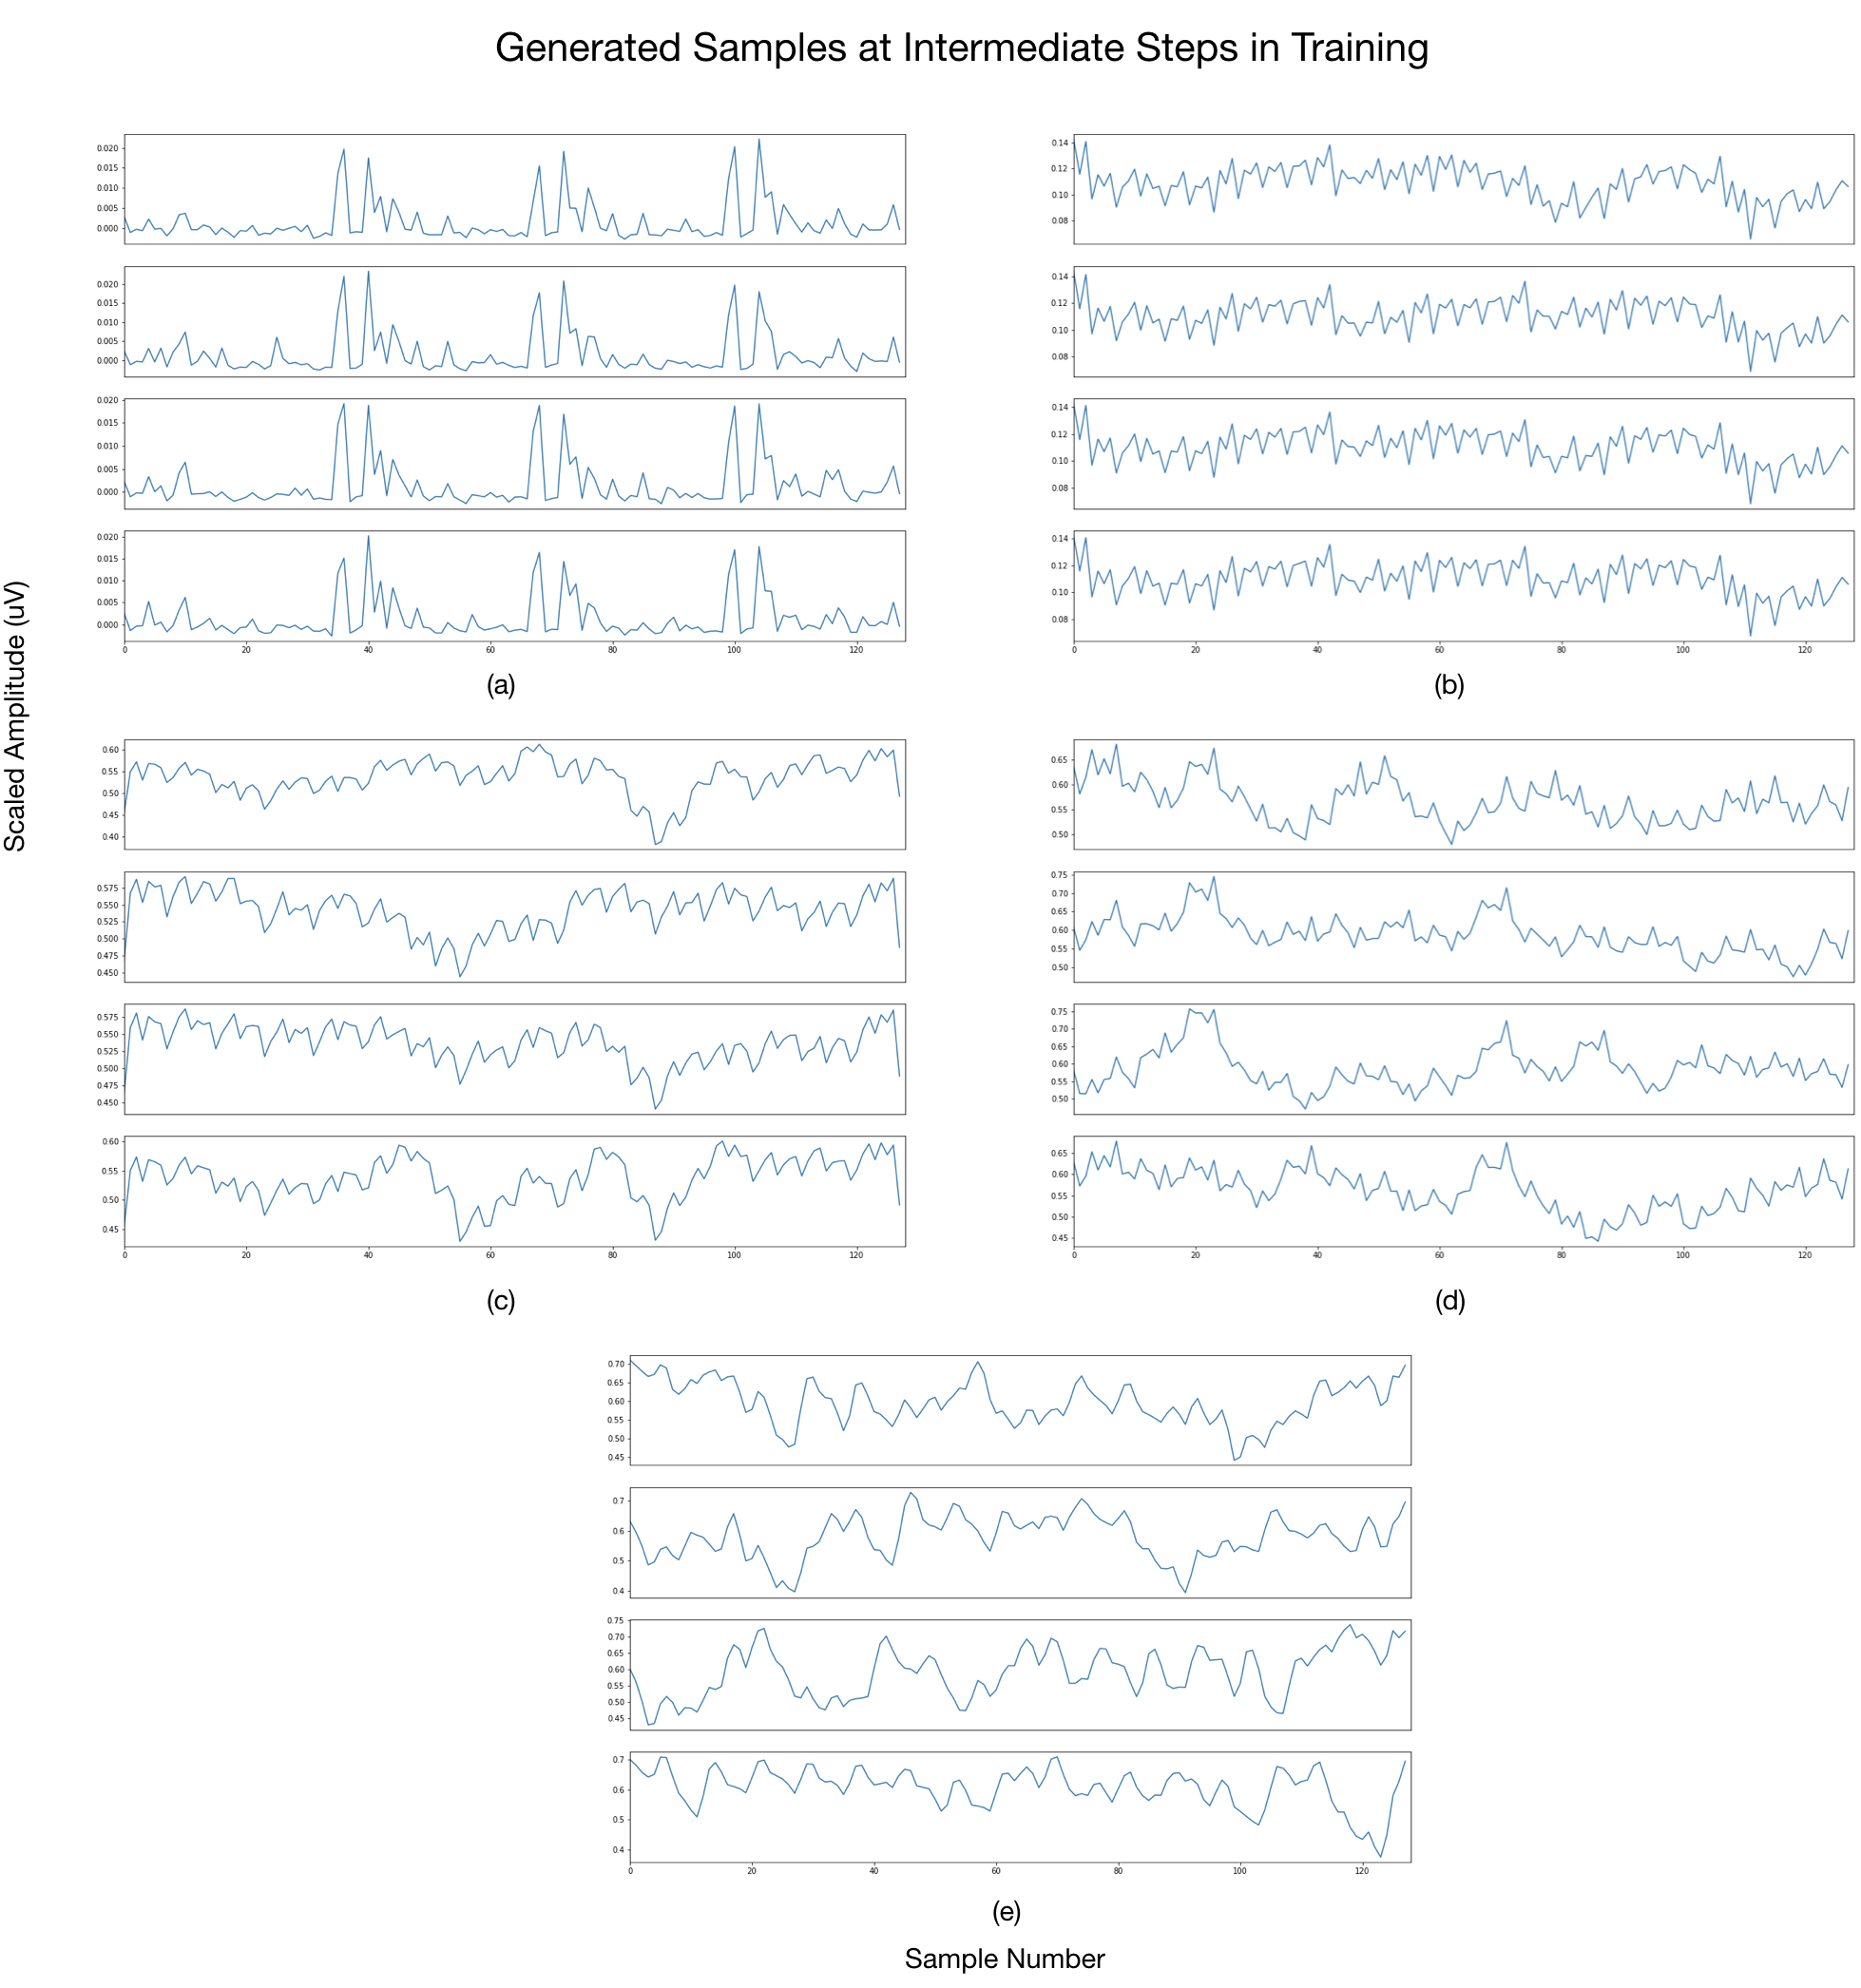

In [0]:
load_img('/content/drive/My Drive/EEG GAN/eeg2 gan/samples g.png')

After analyzing generated samples from numerous intermediate states of the network, I found that the model state after epoch 115 seemed to generate the highest quality synthetic signals.  Provided below are a few samples generated from this model shown alongside real signal segments.  It is worth noting that all of the signal segments from the real dataset were filtered to remove frequency components below 0.5Hz and over 45Hz.  For this reason, I have also shown generated samples that have had this filtering applied to them.  In the unfiltered generated signals, we can observe the presence of excessive high frequency activity (especially in the second channel of the genderated signals).  Filtering the generated signals to remove frequency components below 0.5Hz and over 45Hz results in segments that look more like those of the training data.

In [0]:
# Example dode for generating signal samples with a trained model
trained_gan = eeg2_GAN(bio_channels=2, latent_dims=200, samples_per_seg=128)
trained_gan.generator.load_state_dict(torch.load('/content/drive/My Drive/EEG GAN/eeg2 gan/test2/epoch115g.pth'))
trained_gan.generator.eval()

# Generated 16 samples
noise_vector = torch.randn(16, 200, 1, device=trained_gan.device)
signal_samples = trained_gan.generator(noise_vector).cpu().detach()

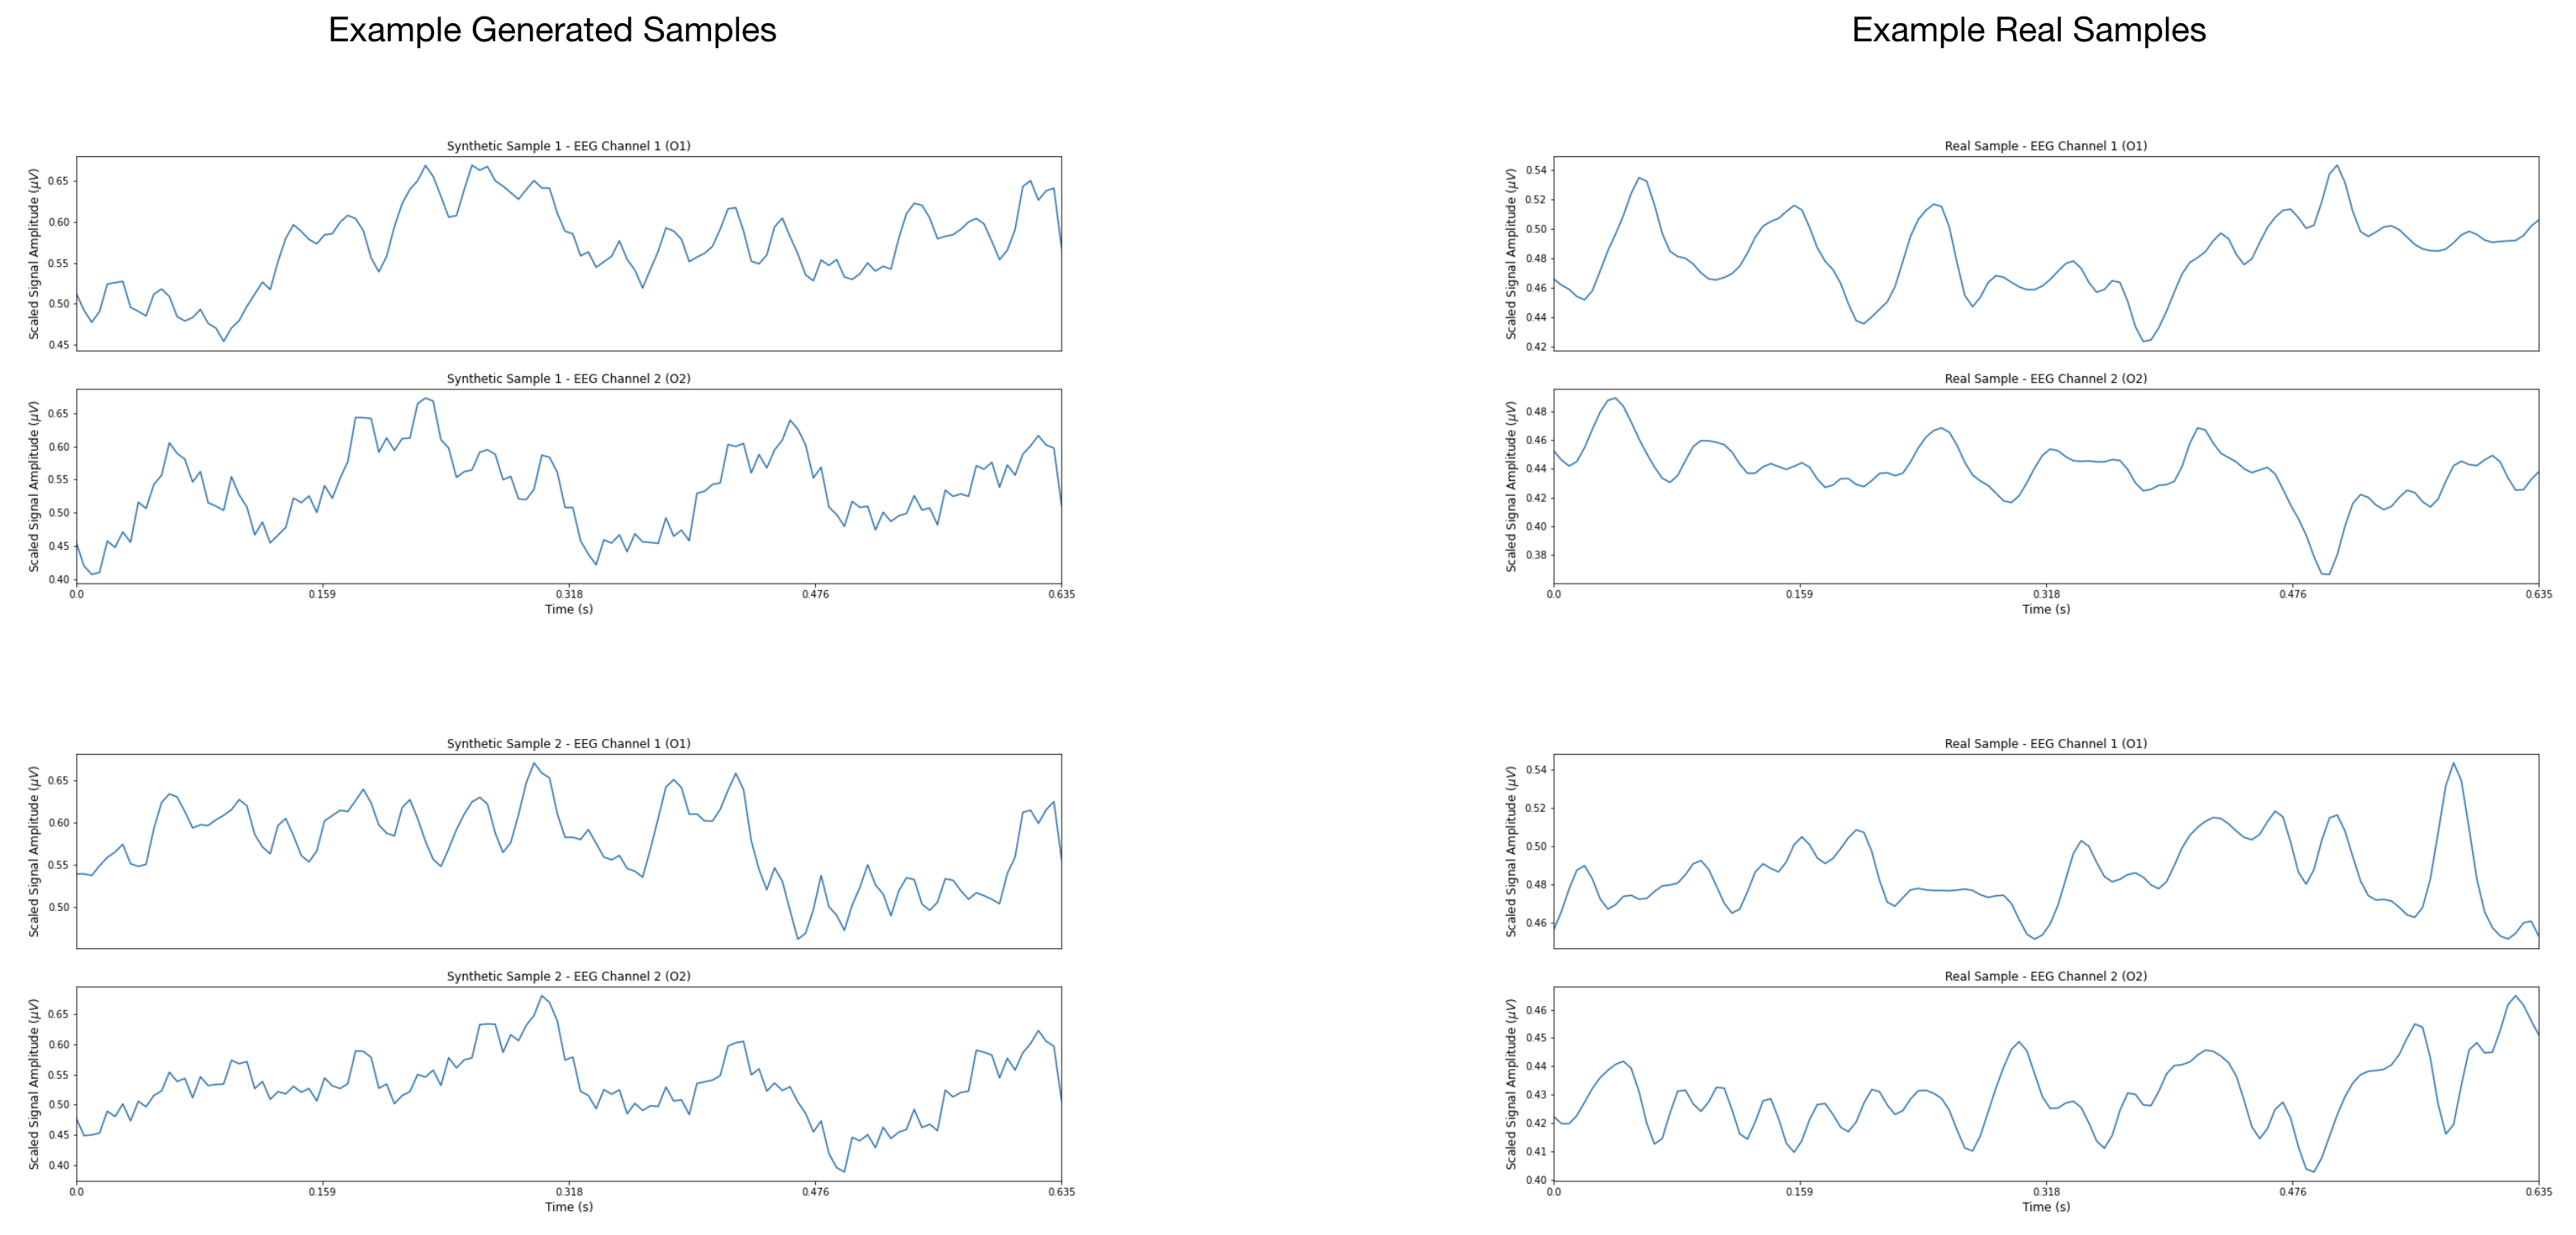

In [0]:
load_img('/content/drive/My Drive/EEG GAN/eeg2 gan/generated vs real samples.png')

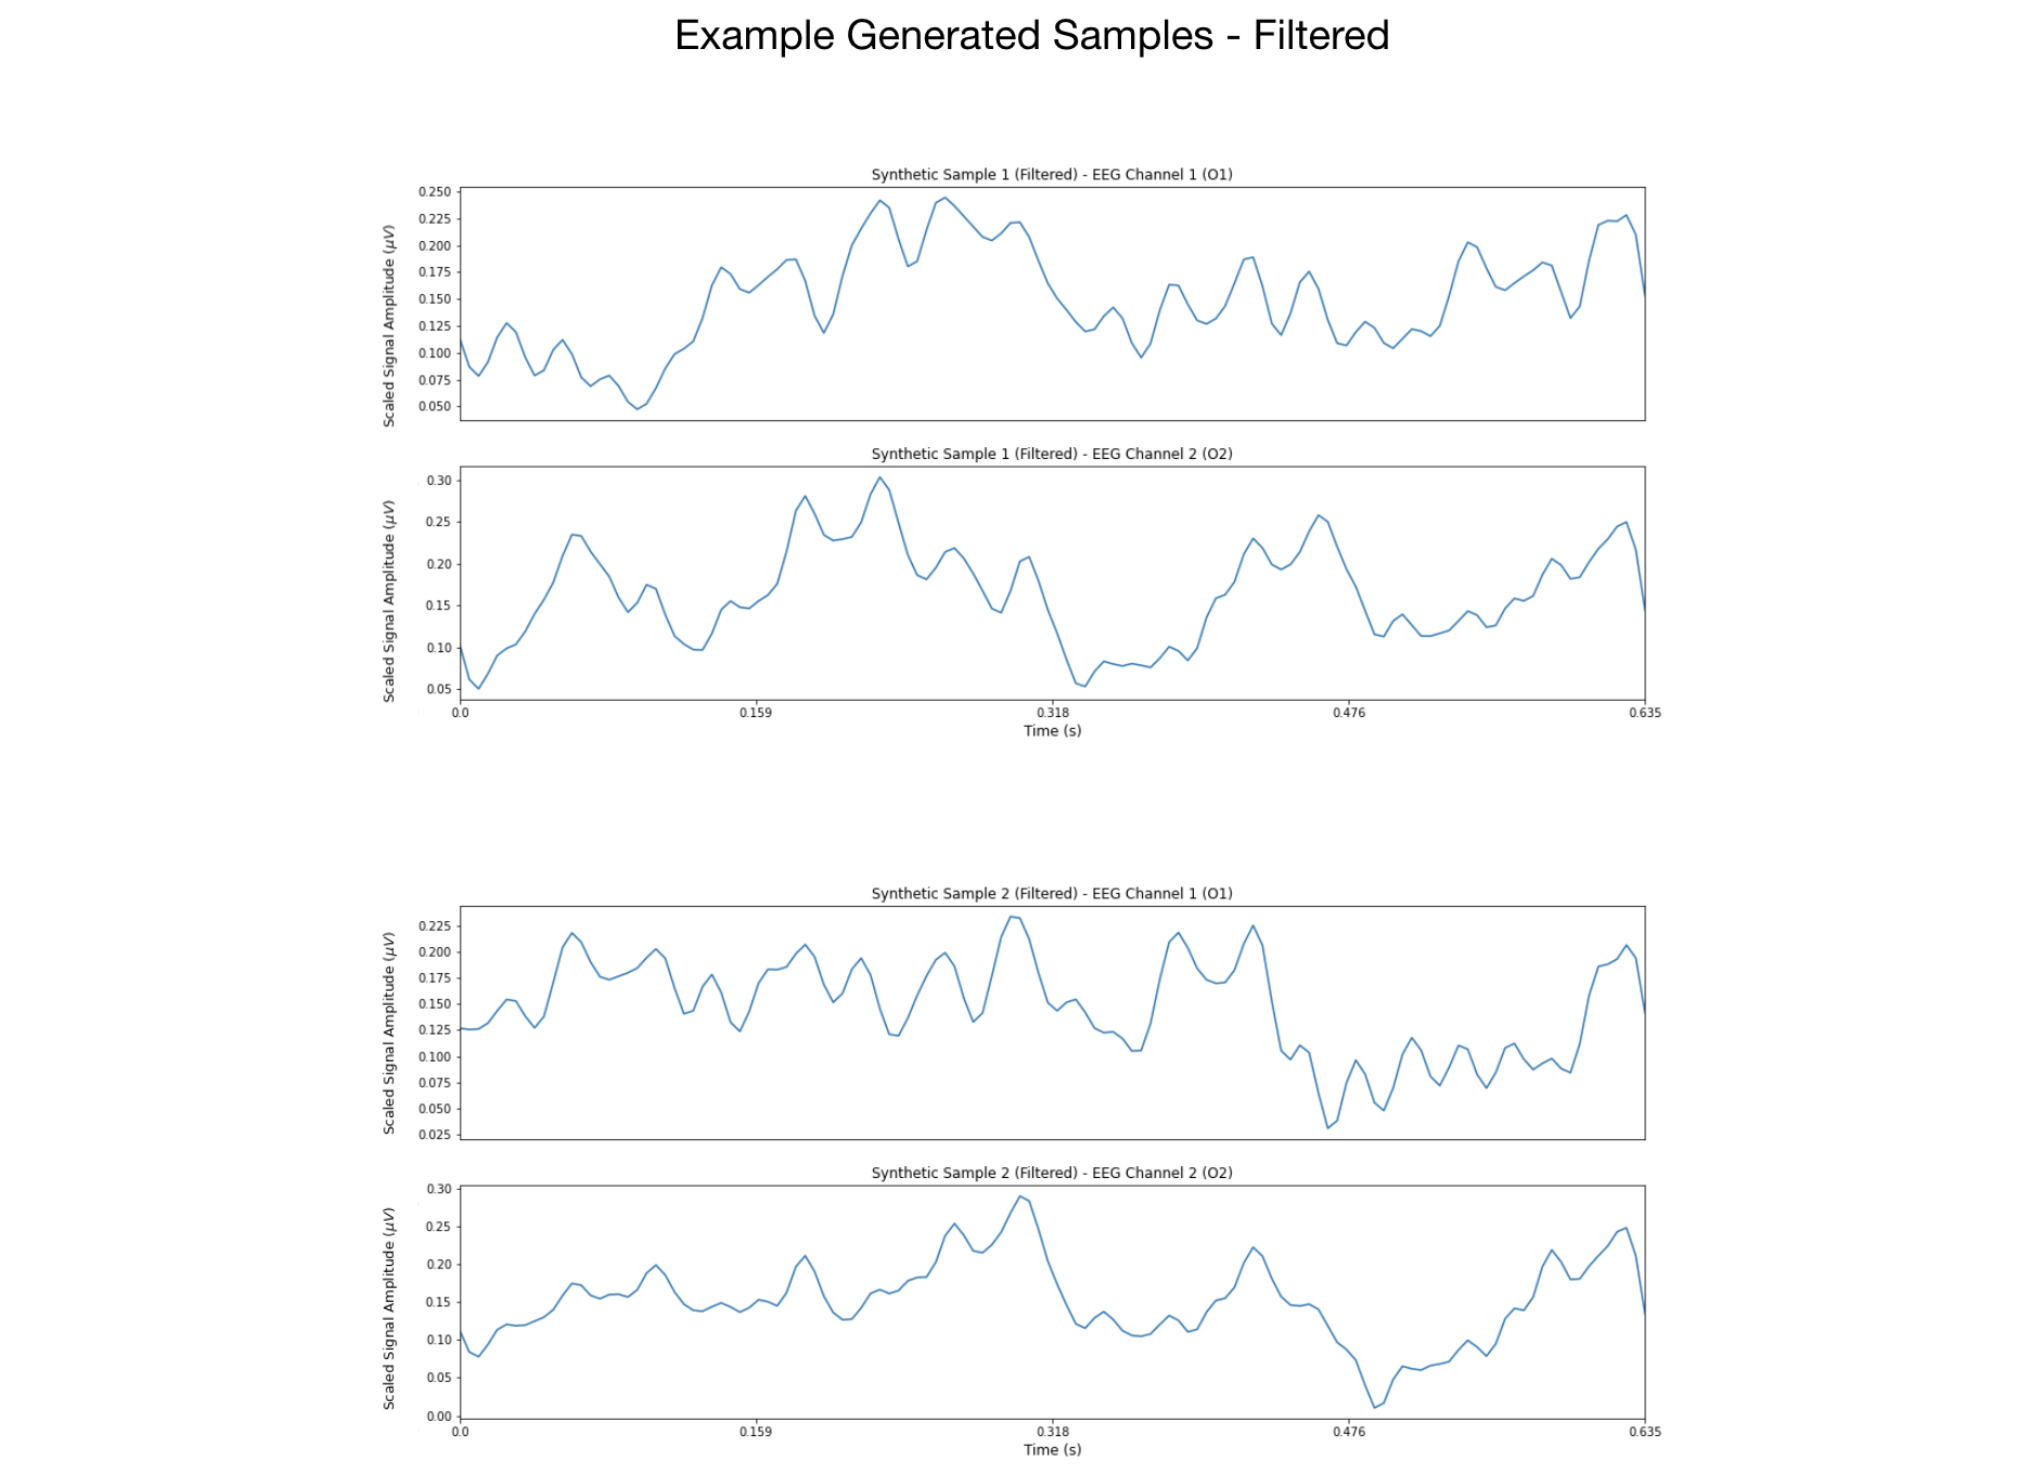

In [0]:
load_img('/content/drive/My Drive/EEG GAN/eeg2 gan/gen signals filtered.png')

Two common sources of evaluation for GANs are the variety of the generated data and how well the generated data resembles the real data.  Subjectively, after visually inspecting many generated signal segments, I believe that the generator is able to produce a signal segments that vary in form.  Regarding the similarity between real and generated signal segments, a common method for comparing two EEG signals is by comparing the amount of activity in each of the signal's respective frequency band components.  The EEG signal is composed of 5 primary waveforms - delta waves (0.5-4Hz), theta waves (4-8Hz), alpha waves (8-12Hz), beta waves (12-30Hz), and gamma waves (> 30Hz).  The amount of activity in each of these waveform components, as given by a metric called the [power spectral density](https://en.wikipedia.org/wiki/Spectral_density), can often be an indicator of one's mental state.  As such, traditional machine learning methods for EEG data often rely on features engineered from these frequency bands. So, if the syntehtic EEG segments are similar to the real EEG segments, then these generated segments should have similar waveform characteristics.  In the code cells below, I randomly sampled 100 real signal segments from the training dataset, generated 100 synthetic signal segments using the training GAN, computed estimates of the power in each of the EEG frequency bands for each segment, and then show high level visualizations of the distributions of these frequency band powers for the real and synthetic EEG segments.

In [0]:
# Randomly sample 100 real segments
inds = np.random.permutation(X_train.shape[0])[:100]
real_segments = X_train[inds]

# Generated 100 synthetic segments
noise_vector = torch.randn(100, 200, 1, device=trained_gan.device)
fake_segments = trained_gan.generator(noise_vector).cpu().detach().numpy()

In [0]:
real_pows = [{'delta': [], 'theta': [], 'alpha': [], 'beta': [], 'low_gamma': []}, \
             {'delta': [], 'theta': [], 'alpha': [], 'beta': [], 'low_gamma': []}]
fake_pows = [{'delta': [], 'theta': [], 'alpha': [], 'beta': [], 'low_gamma': []}, \
             {'delta': [], 'theta': [], 'alpha': [], 'beta': [], 'low_gamma': []}]

# Define EEG frequency bands
delta_range = (0.5, 4)
theta_range = (4, 8)
alpha_range = (8, 12)
beta_range = (12, 30)
low_gama_range = (30, 45)
eeg_frequency_bands = [delta_range, theta_range, alpha_range, beta_range, low_gama_range]

# Estimate power within a given frequency band given the PSD
def compute_band_power(frequencies, psd, freq_low, freq_high):
  frequency_resolution = frequencies[1] - frequencies[0]
  freq_band_indices = np.logical_and(f >= freq_low, f <= freq_high)
  power = simps(psd[freq_band_indices], dx=frequency_resolution)
  return power

for i in range(100):
  # Rescale real sample according to the normalization values
  real_seg_channel1 = (real_segments[i,0,:] * (channel_stats[0][1] - channel_stats[0][0])) + channel_stats[0][0]
  real_seg_channel2 = (real_segments[i,1,:] * (channel_stats[1][1] - channel_stats[1][0])) + channel_stats[1][0]

  # Calculate approximate frequency band powers for each channel of real segment
  for c, real_seg in enumerate([real_seg_channel1, real_seg_channel2]):
    f, psd = signal.welch(real_seg, fs=200, nperseg=128)
    for band_name, band in zip(['delta','theta','alpha','beta','low_gamma'], eeg_frequency_bands):
      power = compute_band_power(f, psd, band[0], band[1])
      real_pows[c][band_name].append(power)

  # Rescale fake sample according to the normalization values
  fake_seg_channel1 = (fake_segments[i,0,:] * (channel_stats[0][1] - channel_stats[0][0])) + channel_stats[0][0]
  fake_seg_channel2 = (fake_segments[i,1,:] * (channel_stats[1][1] - channel_stats[1][0])) + channel_stats[1][0]

  # Calculate approximate frequency band powers for each channel of fake segment
  for c, fake_seg in enumerate([fake_seg_channel1, fake_seg_channel2]):
    f, psd = signal.welch(fake_seg, fs=200, nperseg=128)
    for band_name, band in zip(['delta','theta','alpha','beta','low_gamma'], eeg_frequency_bands):
      power = compute_band_power(f, psd, band[0], band[1])
      fake_pows[c][band_name].append(power)

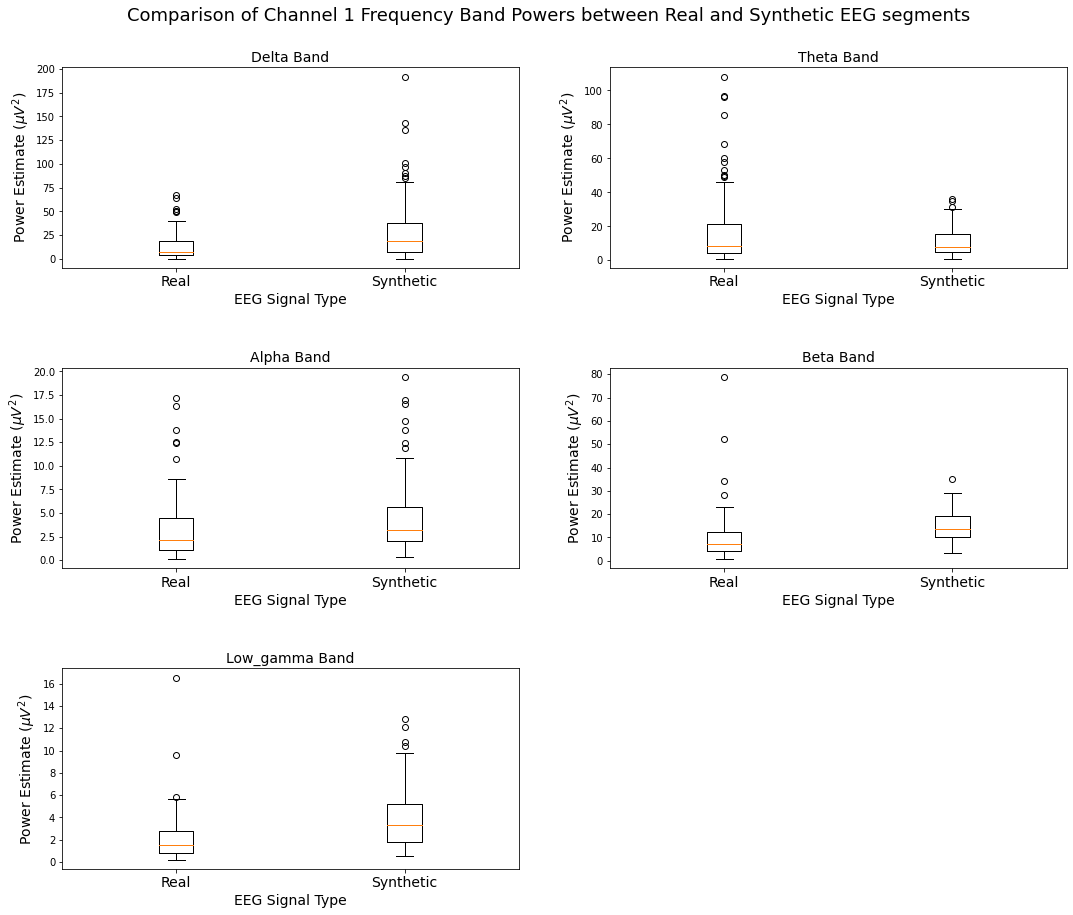

In [0]:
fig, axes = plt.subplots(3, 2, figsize=(18, 14))

plt.suptitle('Comparison of Channel 1 Frequency Band Powers between Real and Synthetic EEG segments', size=18)

for axis, frequency_band in zip(axes.flatten(), ['delta','theta','alpha','beta','low_gamma']):
  axis.boxplot([real_pows[0][frequency_band], fake_pows[0][frequency_band]])
  axis.set_xticklabels(['Real', 'Synthetic'], size=14)
  axis.set_xlabel('EEG Signal Type', size=14)
  axis.set_ylabel('Power Estimate ($\mu V^2$)', size=14)
  axis.set_title('{} Band'.format(frequency_band.capitalize()), size=14)

plt.subplots_adjust(left=None, bottom=None, right=None, top=.92, wspace=None, hspace=0.5)
axes[-1, -1].axis('off')
plt.show()

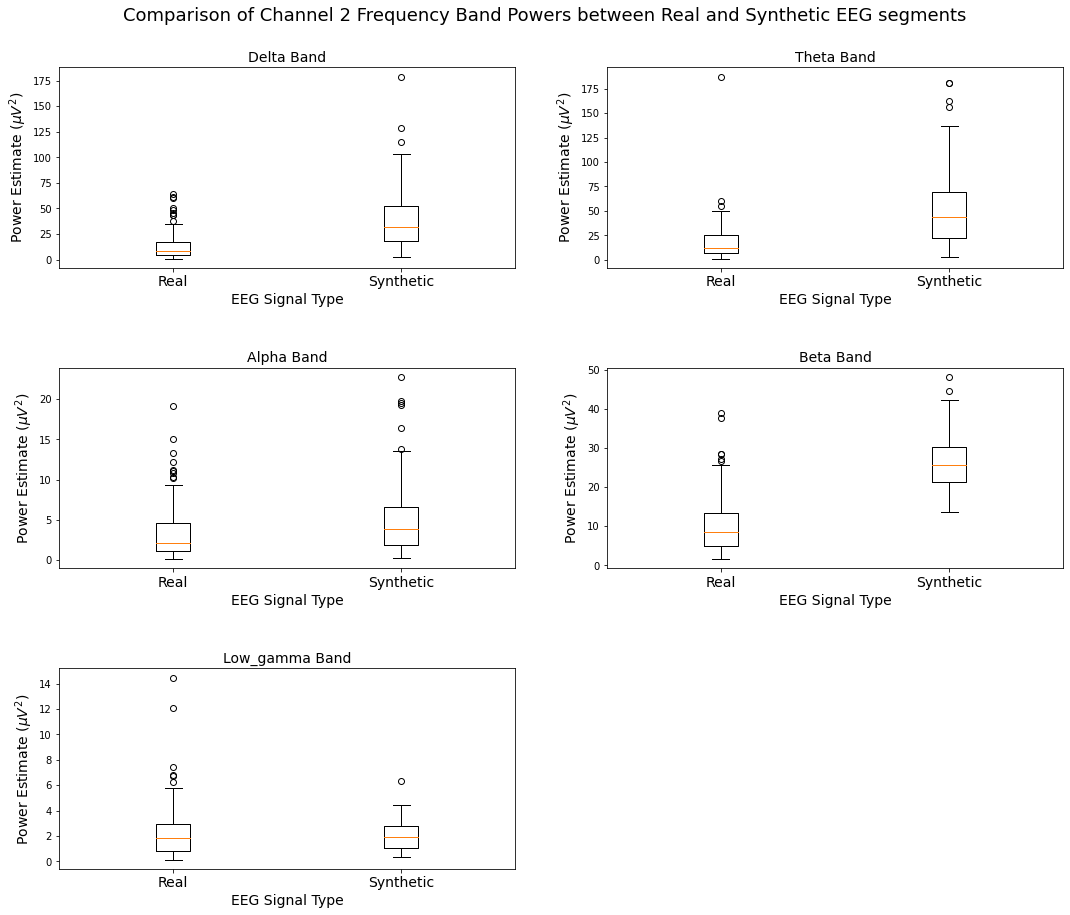

In [0]:
fig, axes = plt.subplots(3, 2, figsize=(18, 14))

plt.suptitle('Comparison of Channel 2 Frequency Band Powers between Real and Synthetic EEG segments', size=18)

for axis, frequency_band in zip(axes.flatten(), ['delta','theta','alpha','beta','low_gamma']):
  axis.boxplot([real_pows[1][frequency_band], fake_pows[1][frequency_band]])
  axis.set_xticklabels(['Real', 'Synthetic'], size=14)
  axis.set_xlabel('EEG Signal Type', size=14)
  axis.set_ylabel('Power Estimate ($\mu V^2$)', size=14)
  axis.set_title('{} Band'.format(frequency_band.capitalize()), size=14)

plt.subplots_adjust(left=None, bottom=None, right=None, top=.92, wspace=None, hspace=0.5)
axes[-1, -1].axis('off')
plt.show()

A rough analysis of the boxplots shown above sheds light on a few similarities and differences between the real and generated signal segments.  First, the middle 50% of the synthetic signal segments tend to have a geater range in power in most EEG frequency bands than the middle 50% of the real signal segments.  This is the case for both channels of the EEG segments.  Similarly, the median power in each frequency band tends to be greater in the synthetic segments.  These differences aside, there are cases in which the generated signal segments have similar EEG waveform components to real segments, indicating that a subset of the generated segments have the potential to be used as additional training samples in a relatively small datasets (a rejection scheme may be used to filter out generated segments that are not resemblant of real EEG segments).  Certainly, a more robust and application specific analysis would need to be performed to validate performance improvement from augmenting a training dataset with these synthetic samples, but Power Spectral Density similarities between real EEG segments and some of the synthetic EEG segments hint at potential benefits.

___

## References
1. [Sampling Strategies for GAN Synthetic Data - Binod Bhattarai, Seungryul Baek, Rumeysa Bodur, Tae-Kyun Kim](https://arxiv.org/abs/1909.04689)
2. [Data Augmentation Using GANs - Fabio Henrique Kiyoiti dos Santos Tanaka, Claus Aranha](https://arxiv.org/abs/1904.09135)
3. [EEG-GAN: Generative adversarial networks for electroencephalograhic (EEG) brain signals - Kay Gregor Hartmann, Robin Tibor Schirrmeister, Tonio Ball](https://arxiv.org/abs/1806.01875)
4. [Maintenance of Wakefulness Test (MWT) recordings - Hertig-Godeschalk Anneke, Skorucak Jelena, Malafeev Alexander, Achermann Peter, Mathis Johannes, Schreier David](https://zenodo.org/record/3251716#.XqW1ei2ZOCN)
5. [Automatically Detected Microsleep Episodes in the Fitness-to-Drive Assessment - Hertig-Godeschalk Anneke, Skorucak Jelena, Achermann Peter, Mathis Johannes, Schreier David](https://www.frontiersin.org/articles/10.3389/fnins.2020.00008/full)
6. [Estimating alertness from the EEG power spectrum - Tzyy-Ping Jung, S. Makeig, M. Stensmo, T.J. Sejnowski](https://ieeexplore.ieee.org/abstract/document/553713)
7. [Automatic detection of drowsiness in EEG records based on multimodal analysis - Agustina Garcés Correa, Lorena Orosco, Eric Laciar](https://www.sciencedirect.com/science/article/abs/pii/S1350453313001690?casa_token=9z1bfcuGgR0AAAAA:XtcTiwXukdIBU03vPsEDxeN_OggH0oDh6JdGWkDpmneCvA4jYT6iDb5vFGJx6puzy4Ruw8Cl4N8)
8. [Recognition of wake-sleep stage 1 multichannel eeg patterns using spectral entropy features for drowsiness detection - N. Sriraam, T. K. Padma Shri, Uma Maheshwari](https://link.springer.com/article/10.1007/s13246-016-0472-8)
9. [Prediction of immediately occurring microsleep events from brain electric signals - Martin Golz, David Sommer, Jarek Krajewski](https://www.researchgate.net/publication/311423605_Prediction_of_immediately_occurring_microsleep_events_from_brain_electric_signals)
10. [On-line automatic detection of driver drowsiness using a single electroencephalographic channel - Antoine Picot, Sylvie Charbonnier, Alice Caplier](https://ieeexplore.ieee.org/document/4650053)
11. [Detecting behavioral microsleeps using EEG and LSTM recurrent neural networks. - Davidson, Jones, Peiris](https://www.ncbi.nlm.nih.gov/pubmed/17281565)
12. [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks - Alec Radford, Luke Metz, Soumith Chintala](https://arxiv.org/abs/1511.06434)
13. [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift - Sergey Ioffe, Christian Szegedy](https://arxiv.org/abs/1502.03167)
14. [Generative Adversarial Networks - Ian J. Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, Yoshua Bengio](https://arxiv.org/abs/1406.2661)
15. [Pytorch DCGAN Tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html#sphx-glr-beginner-dcgan-faces-tutorial-py)
16. [EEG (electroencephalogram) - Mayo Clinic](https://www.mayoclinic.org/tests-procedures/eeg/about/pac-20393875)
17. [Maintenance of Wakefulness Testing Process and Results](http://sleepeducation.org/disease-detection/maintenance-of-wakefulness-test/testing-process-results)
18. [GAN — Ways to improve GAN performance - Jonathan Hui](https://towardsdatascience.com/gan-ways-to-improve-gan-performance-acf37f9f59b)
19. [Gan Hacks](https://github.com/soumith/ganhacks)
20. [How to Identify and Diagnose GAN Failure Modes - Jason Brownlee](https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/)
21. [Automatic detection of microsleep episodes with feature-based machine learning - Jelena Skorucak,  Anneke Hertig-Godeschalk,  David R Schreier,  Alexander Malafeev, Johannes Mathis,  Peter Achermann](https://academic.oup.com/sleep/article/43/1/zsz225/5574726#191469750)



## Image Sources
+ https://www.wetalkuav.com/brain-implant-allows-users-to-control-drones-with-their-mind/eeg-recording/
+ https://www.codeproject.com/Articles/1220276/ReInventing-Neural-Networks